# Challenge Sprint 4 - Previsão de Acidentes com LSTMs (Case Sompo)
 
Integrantes:
 
 
*   Guilherme Gama Bitencourt Souza | RM 565293
*   Carolina Novakc Moraes | RM 565621
 
---
 

In [43]:
import pandas as pd

# 1. Carregar dataset
df = pd.read_csv('datatran2025.csv', encoding='latin1', sep=';')

In [44]:
# FILTRAR PELA BR-116 
BR_FOCO = 116 

print(f"\n--- Iniciando Passo 0: Filtragem pela BR-{BR_FOCO} ---")
print(f"DataFrame original tinha {len(df)} registros.")
df_filtrado = df[df['br'] == BR_FOCO].copy()
print(f"DataFrame filtrado para BR {BR_FOCO} tem {len(df_filtrado)} registros.")


--- Iniciando Passo 0: Filtragem pela BR-116 ---
DataFrame original tinha 53213 registros.
DataFrame filtrado para BR 116 tem 8129 registros.


In [45]:
# 1. Criar o Target 'acidente_grave'
df_filtrado['acidente_grave'] = (df_filtrado['mortos'] > 0).astype(int)

# 2. Criar 'timestamp'
try:
    df_filtrado['data_inversa'] = pd.to_datetime(df_filtrado['data_inversa'], errors='coerce')
    df_filtrado['horario'] = pd.to_datetime(df_filtrado['horario'], format='%H:%M:%S', errors='coerce').dt.time
    df_filtrado['timestamp'] = df_filtrado.apply(
        lambda r: pd.Timestamp.combine(r['data_inversa'], r['horario']) if pd.notnull(r['data_inversa']) and pd.notnull(r['horario']) else pd.NaT, 
        axis=1
    )
    df_filtrado = df_filtrado.dropna(subset=['timestamp'])
    df_filtrado = df_filtrado.set_index('timestamp').sort_index()
except Exception as e:
    print(f"Erro ao combinar data/hora, tentando método alternativo: {e}.")
    if 'timestamp' not in df_filtrado:
        df_filtrado['timestamp'] = pd.to_datetime(df_filtrado['data_inversa'].astype(str) + ' ' + df_filtrado['horario'].astype(str), errors='coerce')
        df_filtrado = df_filtrado.dropna(subset=['timestamp'])
        df_filtrado = df_filtrado.set_index('timestamp').sort_index()

In [46]:
# 3. Coluna "KM"
if 'km' in df_filtrado.columns:
    # 1. Converte para string 
    # 2. Substitui vírgula por ponto
    # 3. Converte para numérico 
    df_filtrado['km'] = pd.to_numeric(
        df_filtrado['km'].astype(str).str.replace(',', '.', regex=False), 
        errors='coerce'
    )

In [ ]:
# 4. Definir features
categorical_features_to_agg = ['condicao_metereologica', 'tipo_pista', 'tracado_via']
numerical_features_to_agg = ['feridos_graves', 'feridos_leves', 'ilesos', 'veiculos', 'mortos']

def get_mode(series):
    if series.empty: return np.nan
    return series.mode().iloc[0]

# 5. Dicionário de Agregação
agg_dict = {
    'acidente_grave': 'max', 
}
for col in numerical_features_to_agg:
    if col in df_filtrado.columns:
        agg_dict[col] = 'sum'
if 'km' in df_filtrado.columns:
    agg_dict['km'] = 'mean' 
for col in categorical_features_to_agg:
    if col in df_filtrado.columns:
        # mais frequente
        agg_dict[col] = get_mode

In [57]:
# 6. Resample para fazer a frequência
df_resampled = df_filtrado.resample('h').agg(agg_dict)

# 7. Limpar NaNs
df_resampled['acidente_grave'] = df_resampled['acidente_grave'].fillna(0).astype(int)
num_cols_to_fill = [col for col in numerical_features_to_agg if col in df_resampled.columns]
df_resampled[num_cols_to_fill] = df_resampled[num_cols_to_fill].fillna(0)
cat_cols_to_fill = [col for col in categorical_features_to_agg if col in df_resampled.columns]
if 'km' in df_resampled.columns:
    cat_cols_to_fill.append('km')
df_resampled[cat_cols_to_fill] = df_resampled[cat_cols_to_fill].ffill().bfill() 

print("\nDados reamostrados e agregados:")
print(df_resampled.head())
print("\nVerificando NaNs restantes:")
print(df_resampled.isna().sum())


Dados reamostrados e agregados:
                     acidente_grave  feridos_graves  feridos_leves  ilesos  \
timestamp                                                                    
2025-01-01 01:00:00               0               0              2       0   
2025-01-01 02:00:00               0               0              0       1   
2025-01-01 03:00:00               1               0              1       1   
2025-01-01 04:00:00               0               0              0       0   
2025-01-01 05:00:00               0               0              0       0   

                     veiculos  mortos    km condicao_metereologica tipo_pista  \
timestamp                                                                       
2025-01-01 01:00:00         1       0   6.7              Céu Claro      Dupla   
2025-01-01 02:00:00         1       0  11.3              Céu Claro      Dupla   
2025-01-01 03:00:00         2       1  14.0                Nublado      Dupla   
2025-01-01 04:0

In [ ]:
target_col = 'acidente_grave'

#Transformar em números
df_resampled['hora_do_dia'] = df_resampled.index.hour
df_resampled['dia_da_semana'] = df_resampled.index.dayofweek

def encode_cyclic(series, max_val):
    sin = np.sin(2 * np.pi * series / max_val)
    cos = np.cos(2 * np.pi * series / max_val)
    return sin, cos

df_resampled['hora_sin'], df_resampled['hora_cos'] = encode_cyclic(df_resampled['hora_do_dia'], 23)
df_resampled['dia_sin'], df_resampled['dia_cos'] = encode_cyclic(df_resampled['dia_da_semana'], 6)

# One-Hot Encoding
cols_to_encode = [col for col in cat_cols_to_fill if col != 'km' and col in df_resampled.columns]
df_processed = pd.get_dummies(df_resampled, columns=cols_to_encode, drop_first=False)

# Para não usar como Features 
cols_to_exclude = [
    target_col, 
    'hora_do_dia', 'dia_da_semana',
    
] + num_cols_to_fill 

features = [col for col in df_processed.columns if col not in cols_to_exclude]

features_to_lag = num_cols_to_fill 
for col in features_to_lag:
    if col in df_processed.columns:
        df_processed[f'{col}_lag1'] = df_processed[col].shift(1)
        features.append(f'{col}_lag1') 

df_processed = df_processed.dropna() 
print(f"\nNúmero total de features: {len(features)}")
print(f"Exemplo de features: {features[:5]}...")



Número total de features: 144
Exemplo de features: ['km', 'hora_sin', 'hora_cos', 'dia_sin', 'dia_cos']...


**Justificativa da Escolha do Target e da Estrutura Temporal:**

    * Escolha do Target: acidente_grave na BR-116
    * Classe 1: A hora contém um ou mais acidentes com mortos (mortos > 0).
    * Classe 0: A hora não contém acidentes com mortos.

    Justificativa:
    * Alto Impacto (Para a Sompo), faria muita diferença na hora de fechar um contrato
    * Viabilidade, mostrar a frequência de acidentes

In [50]:
from sklearn.preprocessing import MinMaxScaler

print("\nPreparação de Dados")

features_scaler = MinMaxScaler()
df_class = df_processed.copy()

# 1. Normalizar 
df_class[features] = features_scaler.fit_transform(df_class[features])

# 2. Preparar o ALVO (y)
target_data = df_class[target_col].values 

print(pd.Series(target_data).value_counts(normalize=True).sort_index())

# 3. Criar Sequências 
def create_sequences(data_features, data_target, look_back=24):
    X, y = [], []
    print(f"Criando sequências... Total de {len(data_features) - look_back} sequências a serem criadas.")
    for i in range(len(data_features) - look_back):
        X.append(data_features[i:(i + look_back)])
        y.append(data_target[i + look_back])
    print("Criação de sequências concluída.")
    return np.array(X), np.array(y)

look_back = 24 
features_data = df_class[features].values
X, y = create_sequences(features_data, target_data, look_back)

# Verificar se alguma sequência foi criada
if X.shape[0] == 0:
    print("\nERRO")
else:
    print(f"\nFormato de X (amostras, timesteps, features): {X.shape}") 
    print(f"Formato de y (amostras,): {y.shape}")

    # 4. Divisão Train/Test (Split Temporal)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    print(f"Total de amostras: {len(X)}")
    print(f"Amostras de Treino: {len(X_train)}")
    print(f"Amostras de Teste: {len(X_test)}")


Preparação de Dados
0    0.93374
1    0.06626
Name: proportion, dtype: float64
Criando sequências... Total de 6526 sequências a serem criadas.
Criação de sequências concluída.

Formato de X (amostras, timesteps, features): (6526, 24, 144)
Formato de y (amostras,): (6526,)
Total de amostras: 6526
Amostras de Treino: 5220
Amostras de Teste: 1306


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import class_weight

print("\nModelo")

# 1. Calcular Class Weights 
try:
    unique_classes_train = np.unique(y_train)
    if len(unique_classes_train) > 1:
        class_weights_calc = class_weight.compute_class_weight(
            'balanced',
            classes=unique_classes_train,
            y=y_train
        )
        class_weights = {unique_classes_train[i]: class_weights_calc[i] for i in range(len(unique_classes_train))}
        print(f"Pesos das Classes: {class_weights}")
    else:
        print("Aviso")
        class_weights = None
except ValueError:
    print("Erro ao calcular pesos de classe.")
    class_weights = None

# 2. Definir parâmetros do modelo
n_timesteps = X_train.shape[1] 
n_features = X_train.shape[2]  

print(f"O modelo será treinado com timesteps={n_timesteps} e features={n_features}")

# 3. Arquitetura 
model = Sequential([
    LSTM(16, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 4. Compilação (Usando loss binária)
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()


Modelo
Pesos das Classes: {np.int64(0): np.float64(0.5337423312883436), np.int64(1): np.float64(7.909090909090909)}
O modelo será treinado com timesteps=24 e features=144


c:\Users\zecro\OneDrive\Desktop\challenge-sprint-4-redes\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 16)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,449 (40.82 KB)

 Trainable params: 10,449 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Treinamento e Avaliação


Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6812 - loss: 0.6947 - val_accuracy: 0.2764 - val_loss: 0.6936
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4893 - loss: 0.6935 - val_accuracy: 0.2887 - val_loss: 0.6961
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4527 - loss: 0.6912 - val_accuracy: 0.4066 - val_loss: 0.6951
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5571 - loss: 0.6897 - val_accuracy: 0.4127 - val_loss: 0.7022
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5331 - loss: 0.6816 - val_accuracy: 0.5490 - val_loss: 0.6912
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5718 - loss: 0.6741 - val_accuracy: 0.5505 - val_loss: 0.6752
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5657 - loss: 0.6614 - val_accuracy: 0.6286 - val_loss: 0.6351
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5563 - loss: 0.6616 - val_accuracy: 0.

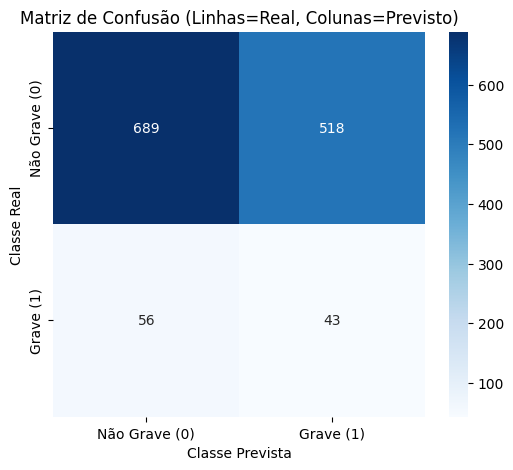

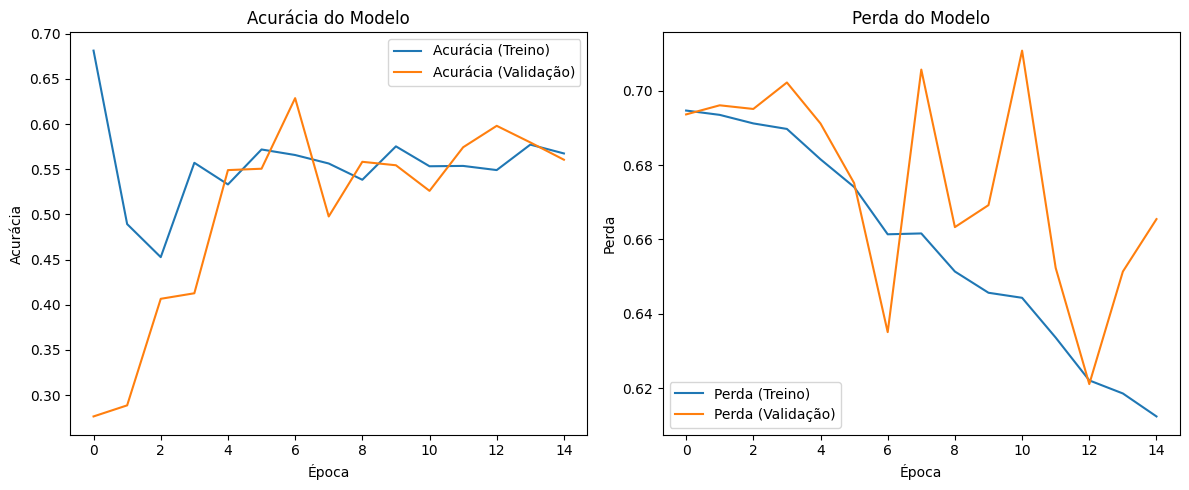

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\nTreinamento e Avaliação")

# 1. Treinar o modelo 
history = model.fit(
    X_train, y_train,
    epochs=15, 
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights, 
    verbose=1,
    shuffle=False 
)

# 2. Salvar o Modelo
modelo_filename = 'modelo_acidente_grave_lstm.keras'
model.save(modelo_filename)
print(f"\nModelo treinado salvo com sucesso como: '{modelo_filename}'")


# 3. Avaliação
y_pred_proba = model.predict(X_test).flatten() 
y_pred_classes = (y_pred_proba > 0.5).astype(int) 

# 4. Gerar Relatórios
print("\n--- Relatório de Classificação (Teste) - BR-116 'Acidente Grave' ---")
print(classification_report(y_test, y_pred_classes, zero_division=0))

print("\n--- Matriz de Confusão - BR-116 'Acidente Grave' ---")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

# 5. Matriz de Confusão
try:
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Grave (0)', 'Grave (1)'], 
                yticklabels=['Não Grave (0)', 'Grave (1)'])
    plt.title('Matriz de Confusão (Linhas=Real, Colunas=Previsto)')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Prevista')
    plt.savefig('matriz_confusao_acidente_grave.png')
    print("Matriz de confusão salva como 'matriz_confusao_acidente_grave.png'")
except Exception as e:
    print(f"Erro ao plotar matriz: {e}")

# 6. Plotar Curvas de Treinamento (Loss/Accuracy)
try:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia (Treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda (Treino)')
    plt.plot(history.history['val_loss'], label='Perda (Validação)')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('curvas_treinamento.png')
    print("Gráficos de treinamento salvos como 'curvas_treinamento.png'")
except Exception as e:
    print(f"Erro ao plotar curvas de treinamento: {e}")


Plotar Previsão
Gráfico de probabilidades salvo como 'previsao_probabilidades_grave_ultimas_24h.png'

--- Pipeline de 'Acidente Grave' Concluído ---


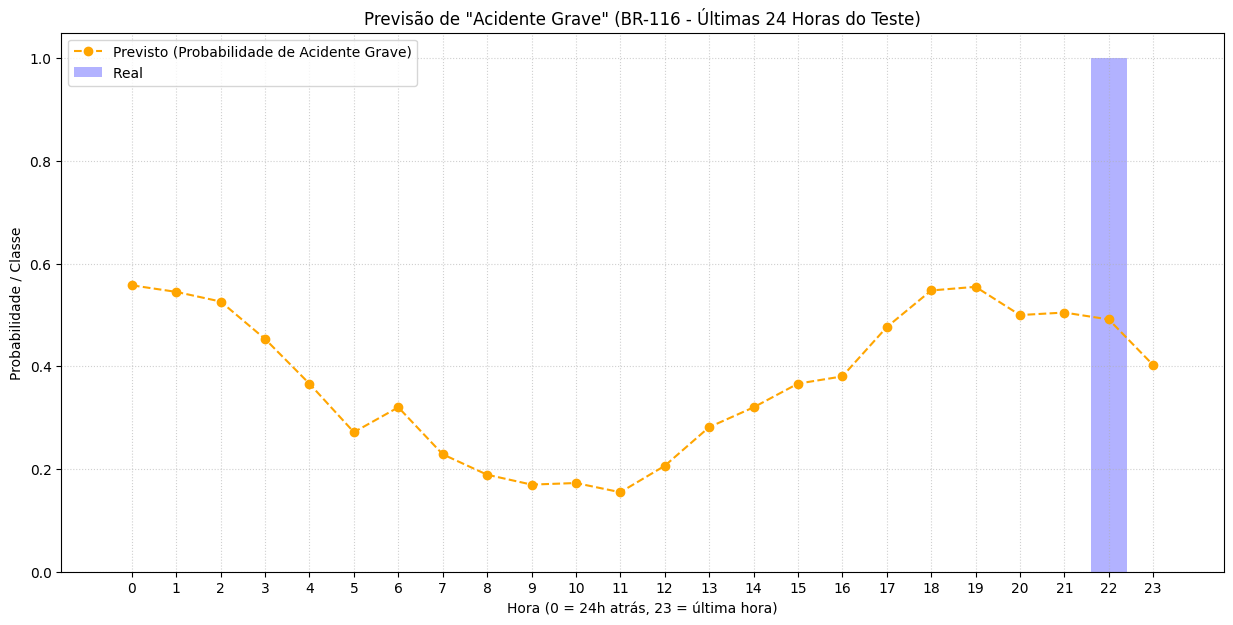

In [59]:
import matplotlib.pyplot as plt
import numpy as np

print("\nPlotar Previsão")
plot_len = 24 

if len(y_test) < plot_len:
    print(f"Aviso: Conjunto de teste tem apenas {len(y_test)} pontos. Plotando todos.")
    plot_len = len(y_test)

if plot_len > 0:
    try:
        plt.figure(figsize=(15, 7)) 
        x_axis = range(plot_len) 
        
        y_real_plot = y_test[-plot_len:]
        y_proba_plot = y_pred_proba[-plot_len:]

        plt.bar(x_axis, y_real_plot, label='Real ', 
                color='blue', alpha=0.3)
        
        plt.plot(x_axis, y_proba_plot, 
                 label='Previsto (Probabilidade de Acidente Grave)', 
                 color='orange', linestyle='--', marker='o')

        plt.title(f'Previsão de "Acidente Grave" (BR-116 - Últimas {plot_len} Horas do Teste)')
        plt.ylabel('Probabilidade / Classe')
        plt.xlabel('Hora (0 = 24h atrás, 23 = última hora)')
        plt.xticks(x_axis) 
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.6)
        
        output_filename = 'previsao_probabilidades_grave_ultimas_24h.png'
        plt.savefig(output_filename)
        print(f"Gráfico de probabilidades salvo como '{output_filename}'")

    except Exception as e:
        print(f"Erro ao gerar o gráfico: {e}")
else:
    print("Nenhum dado de teste para plotar.")

print("\n--- Pipeline de 'Acidente Grave' Concluído ---")